In [1]:
"""
NYC Floodplain Analysis - Terence Barrett, March 2024
"""
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Parameters
community_districts_shp = 'data/Community Districts/geo_export_ae7ecfd5-1d60-4171-ab76-4e2894b9f83d.shp'
floodplain_shp = 'data/Sea Level Rise Maps (2050s 500-year Floodplain)/geo_export_dbd152c8-b86e-421f-8f1c-f011e61276bc.shp'
cd_boroughs = {1: 'Manhattan', 2: 'Bronx', 3: 'Brooklyn', 4: 'Queens', 5: 'Staten Island'}
crs_epsg_to_project_to = 32618  # WGS84 18N, meter

In [3]:
def read_shp_and_project(path_to_shp, projection_epsg):
    """
    Read shapefile into geodataframe, verify CRS, project to target CRS,
    and verify projection was successful
    """
    print(f'\nProcessing shapefile: {path_to_shp}\n')
    input_gdf = gpd.read_file(path_to_shp)
    print('Input CRS:\n', repr(input_gdf.crs))
    projected_gdf = input_gdf.to_crs(epsg=projection_epsg)
    print('Projected CRS:\n', repr(projected_gdf.crs))
    return projected_gdf

In [4]:
print('Create community-district geodataframe, adding a field '
      'with borough names')
community_districts_projected_gdf = (
    read_shp_and_project(path_to_shp=community_districts_shp,
                         projection_epsg=crs_epsg_to_project_to)
)
community_districts_projected_gdf.drop(columns=['shape_area', 'shape_leng'],
                                       inplace=True)
community_districts_projected_gdf['boro_cd'] = \
    community_districts_projected_gdf['boro_cd'].astype(int)
community_districts_projected_gdf['boro_code'] = \
    community_districts_projected_gdf[
        'boro_cd'
    ].astype('str').str.slice(stop=1).astype(int)
community_districts_projected_gdf['boro_name'] = \
    community_districts_projected_gdf['boro_code'].map(cd_boroughs)
community_districts_projected_gdf.set_index('boro_cd', drop=False, inplace=True)

Create community-district geodataframe, adding a field with borough names

Processing shapefile: data/Community Districts/geo_export_ae7ecfd5-1d60-4171-ab76-4e2894b9f83d.shp
Input CRS:
 <Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich
Projected CRS:
 <Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World G

In [10]:
community_districts_projected_gdf.head()

geometry  boro_code  \
boro_cd                                                                 
311      POLYGON ((586882.108 4495840.053, 586919.105 4...          3   
313      POLYGON ((585991.251 4494387.231, 586048.881 4...          3   
312      POLYGON ((586966.110 4500220.077, 586982.658 4...          3   
206      POLYGON ((595104.064 4522025.643, 595098.533 4...          2   
226      POLYGON ((595351.944 4528599.454, 595347.298 4...          2   

        boro_name  
boro_cd            
311      Brooklyn  
313      Brooklyn  
312      Brooklyn  
206         Bronx  
226         Bronx

In [5]:
print('Create floodplain-by-district geodataframe and calculate projected '
      'floodplain area by district')
floodplain_projected_gdf = (
    read_shp_and_project(path_to_shp=floodplain_shp,
                         projection_epsg=crs_epsg_to_project_to)
)
floodplain_projected_gdf.drop(columns=['abfe_0_2pc', 'fld_zone', 'gridcode',
                                       'join_count', 'shape_area', 'shape_leng',
                                       'static_bfe'],
                              inplace=True)
floodplain_by_district_gdf = \
    gpd.overlay(
        community_districts_projected_gdf[['boro_cd', 'geometry']],
        floodplain_projected_gdf,
        how='intersection'
    ).dissolve(
        by='boro_cd'
    )
floodplain_by_district_gdf['floodplain_area_sq_km'] = \
        1e-6 * floodplain_by_district_gdf.geometry.area

Create floodplain-by-district geodataframe and calculate projected floodplain area by district

Processing shapefile: data/Sea Level Rise Maps (2050s 500-year Floodplain)/geo_export_dbd152c8-b86e-421f-8f1c-f011e61276bc.shp
Input CRS:
 <Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich
Projected CRS:
 <Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone

In [11]:
floodplain_by_district_gdf.head()

geometry  \
boro_cd                                                      
101      MULTIPOLYGON (((582525.314 4504142.085, 582523...   
102      MULTIPOLYGON (((583315.661 4508878.160, 583406...   
103      MULTIPOLYGON (((584526.050 4506832.558, 584522...   
104      MULTIPOLYGON (((583615.836 4510694.536, 583616...   
106      MULTIPOLYGON (((586300.696 4509224.497, 586208...   

         floodplain_area_sq_km  
boro_cd                         
101                   2.968845  
102                   1.304414  
103                   1.906270  
104                   1.847391  
106                   1.090471

In [6]:
print('Join floodplain areas to districts (filling in zero for districts with '
      'no floodplain); calculate projected district areas and fraction of that '
      'that is floodplain')
community_districts_projected_gdf.drop(columns='boro_cd', inplace=True)
community_districts_with_floodplain_gdf = \
    gpd.GeoDataFrame(community_districts_projected_gdf.merge(
        right=floodplain_by_district_gdf,
        how='left',
        left_index=True,
        right_index=True,
        suffixes=('_district', '_floodplain')
    ).sort_index().fillna(value={'floodplain_area_sq_km': 0}),
                          geometry='geometry_district',
                          crs=f'EPSG:{crs_epsg_to_project_to}')
community_districts_with_floodplain_gdf['total_area_sq_km'] = \
    1e-6 * community_districts_with_floodplain_gdf.geometry.area
community_districts_with_floodplain_gdf['floodplain_fraction'] = \
    community_districts_with_floodplain_gdf['floodplain_area_sq_km'] \
    / community_districts_with_floodplain_gdf['total_area_sq_km']

Join floodplain areas to districts (filling in zero for districts with no floodplain); calculate projected district areas and fraction of that that is floodplain


In [7]:
print('Create and write district report')
community_districts_floodplain_report_df = \
    community_districts_with_floodplain_gdf.drop(
        columns=['geometry_district', 'geometry_floodplain', 'boro_code'])
community_districts_floodplain_report_df.to_csv('results/district_floodplain.csv')

Create and write district report


In [13]:
community_districts_floodplain_report_df.head()

boro_name  floodplain_area_sq_km  total_area_sq_km  \
boro_cd                                                       
101      Manhattan               2.968845          3.963377   
102      Manhattan               1.304414          3.499288   
103      Manhattan               1.906270          4.352571   
104      Manhattan               1.847391          4.578404   
105      Manhattan               0.000000          4.065783   

         floodplain_fraction  
boro_cd                       
101                 0.749069  
102                 0.372766  
103                 0.437964  
104                 0.403501  
105                 0.000000

In [8]:
print('Create and write borough/city summary report')
boroughs_floodplain_report_df = \
    community_districts_floodplain_report_df.drop(
        columns=['floodplain_fraction']
    ).groupby(by='boro_name').sum()
city_stats_df = pd.DataFrame.from_dict(
    {'Total': [
        boroughs_floodplain_report_df['floodplain_area_sq_km'].sum(),
        boroughs_floodplain_report_df['total_area_sq_km'].sum()
    ]},
    orient='index',
    columns=['floodplain_area_sq_km', 'total_area_sq_km']
)
boroughs_floodplain_report_df = \
    pd.concat([boroughs_floodplain_report_df, city_stats_df])
boroughs_floodplain_report_df['floodplain_fraction'] = \
    boroughs_floodplain_report_df['floodplain_area_sq_km'] \
    / boroughs_floodplain_report_df['total_area_sq_km']
boroughs_floodplain_report_df.to_csv('results/borough_floodplain.csv')

Create and write borough/city summary report


In [15]:
print(boroughs_floodplain_report_df)

               floodplain_area_sq_km  total_area_sq_km  floodplain_fraction
Bronx                      25.978519        108.796505             0.238781
Brooklyn                   68.615526        179.806631             0.381607
Manhattan                  16.710137         58.569733             0.285303
Queens                     82.453106        284.332689             0.289988
Staten Island              42.150605        150.749404             0.279607
Total                     235.907893        782.254962             0.301574


Create and write map image


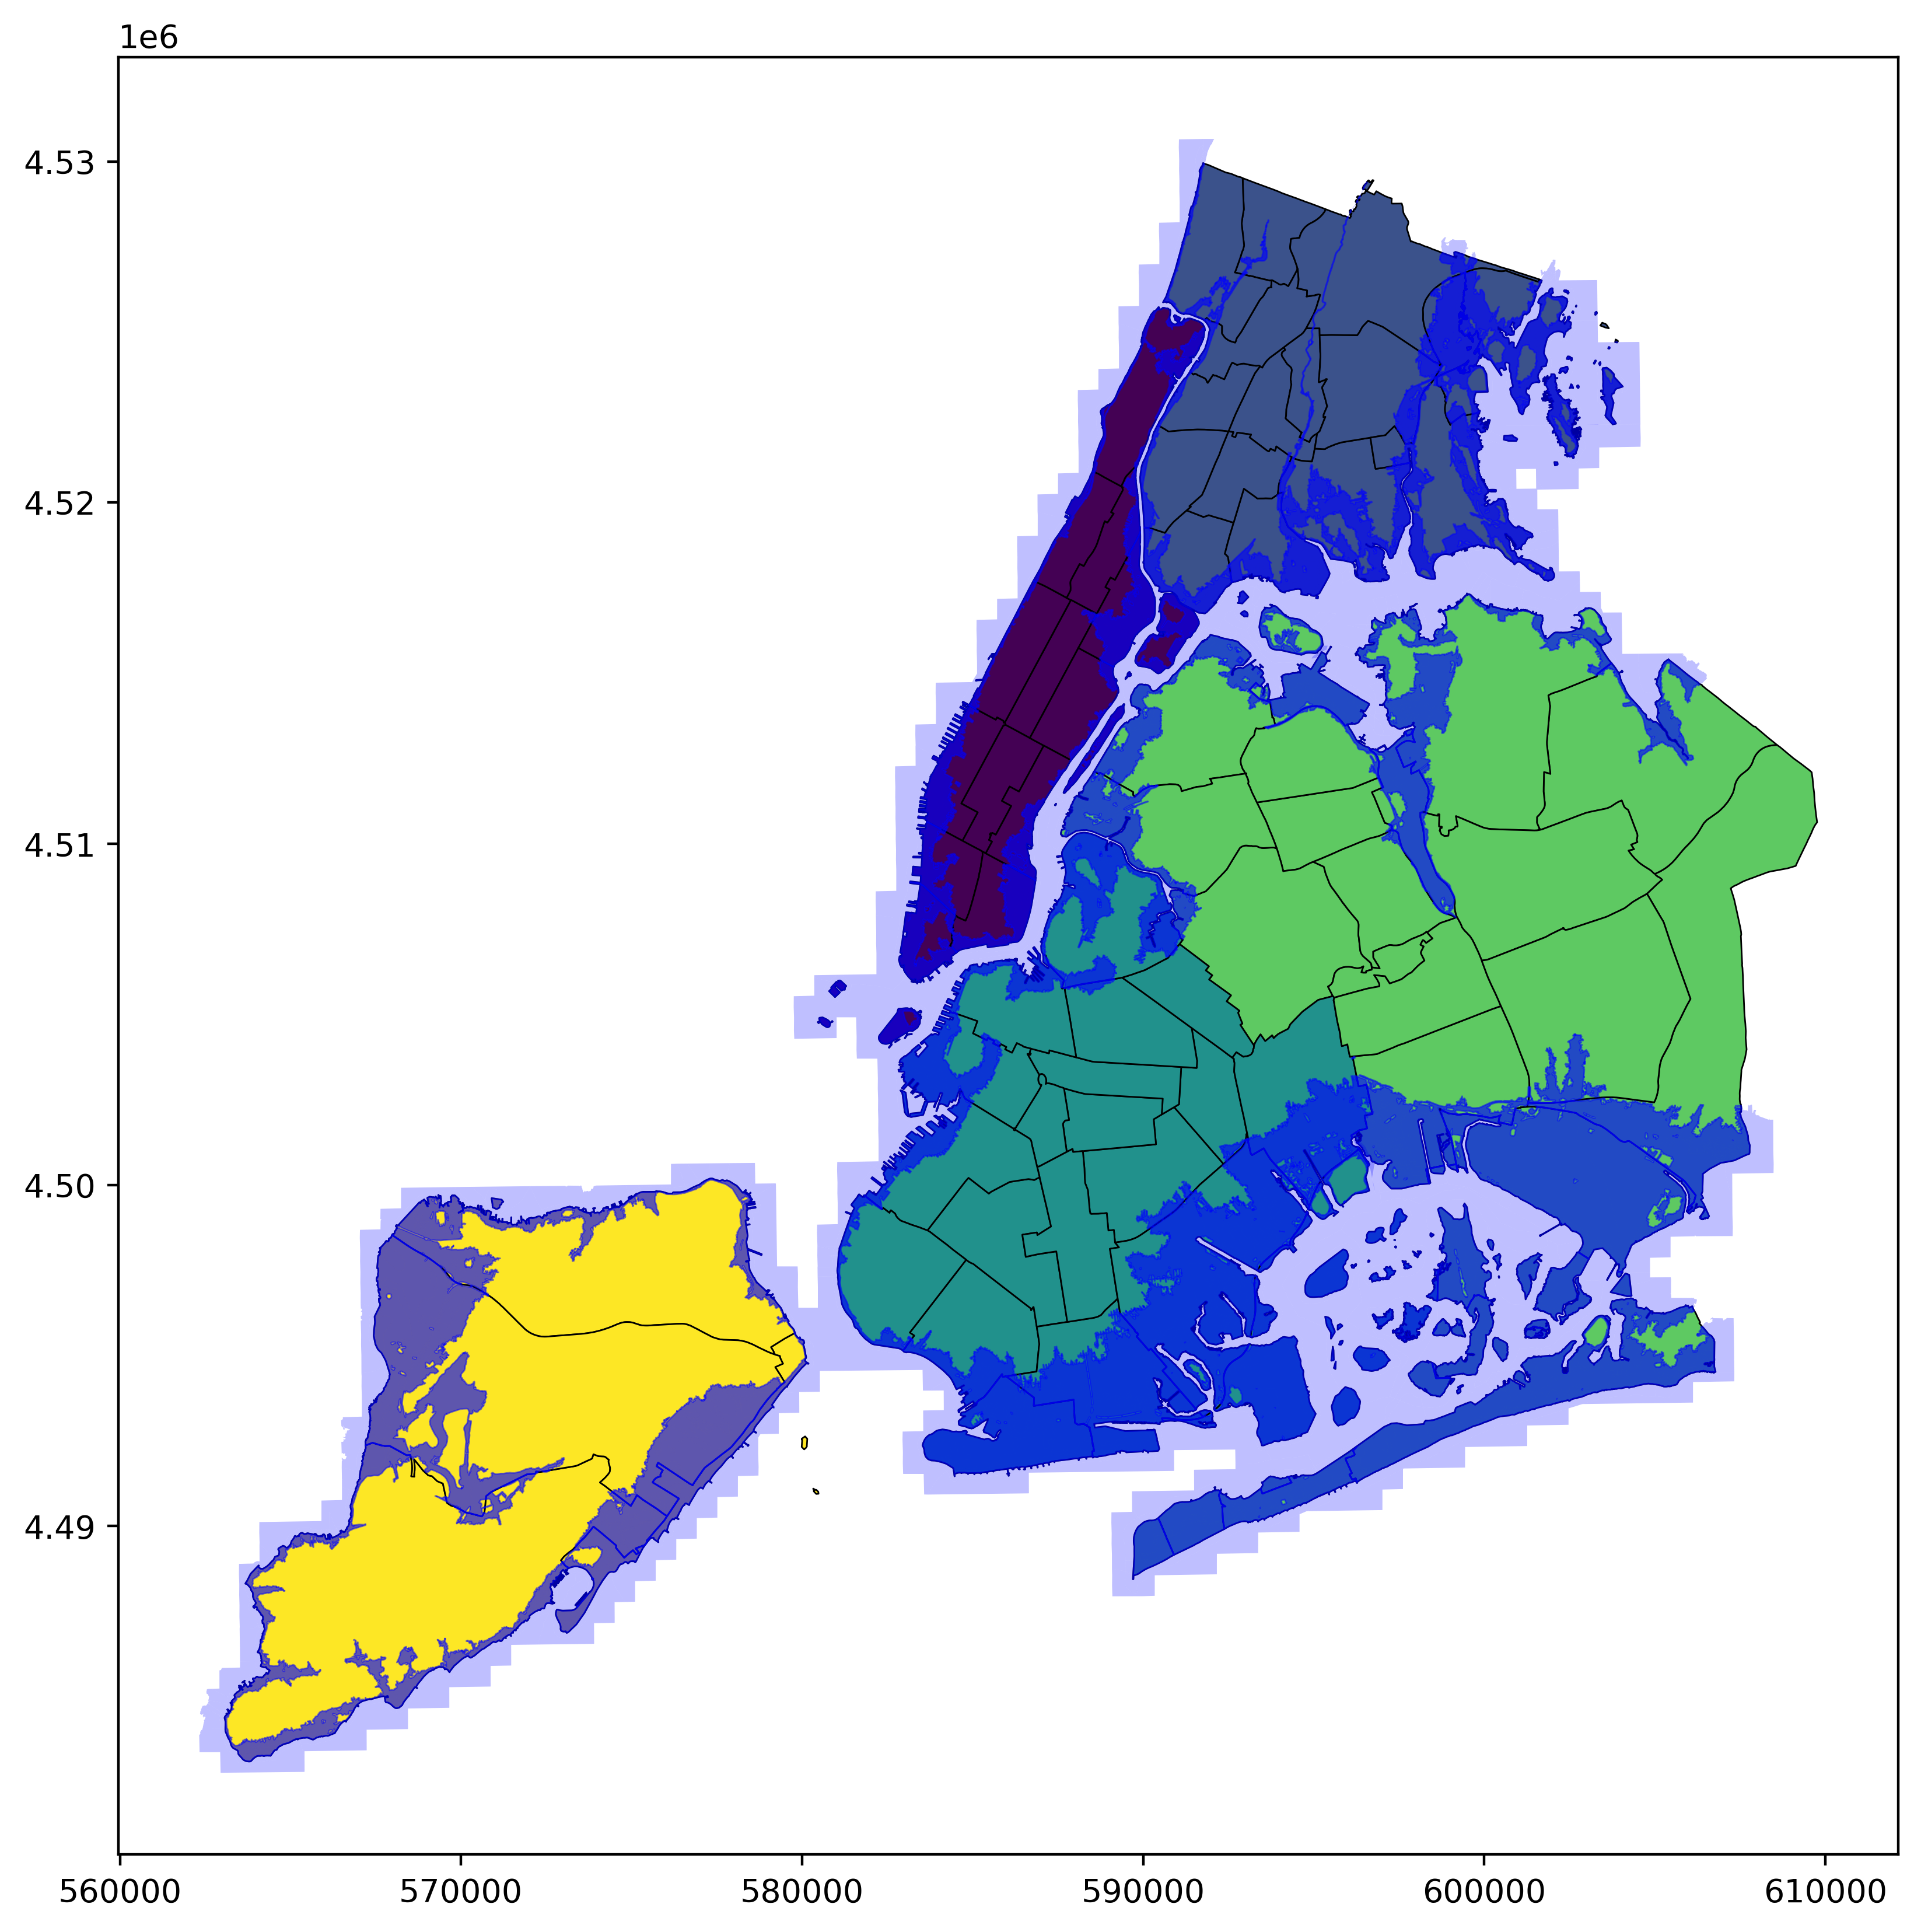

In [9]:
print('Create and write map image')
fig = plt.figure(figsize=(10, 10), dpi=400)
ax = plt.gca()
cd_plot = community_districts_projected_gdf.plot(
    ax=ax, facecolor="gray", edgecolor="black",
    linewidth=0.5, column='boro_code')
water_plot = floodplain_projected_gdf.plot(
    ax=ax, facecolor="blue", edgecolor="none",
    alpha=0.25)
floodplain_plot = floodplain_by_district_gdf.plot(
    ax=ax, facecolor="blue", edgecolor="blue",
    linewidth=0.5, alpha=0.5)
plt.savefig('results/nyc_floodplain_map.png')